In [219]:
from sklearn.base import BaseEstimator
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn import datasets
import numpy as np
import pandas as pd

### Градиентный бустинг (20 баллов)


В текущем ДЗ вам предлагается дописать свою реализацию градиентного бустинга над решающими деревьями. Основной костяк класса прописан, вам нужно заполнить строчки с TODO.

In [127]:
# Параметрами с которыми вы хотите обучать деревья
TREE_PARAMS_DICT = {'max_depth': 3, 'min_samples_leaf': 10}
# Параметр tau (learning_rate) для вашего GB
TAU = 0.1

In [197]:
class SimpleGB(BaseEstimator):
    def __init__(self, tree_params_dict, iters, tau):
        self.tree_params_dict = tree_params_dict
        self.iters = iters
        self.tau = tau
        self.estimators = []
        self.scores = []
        
    def fit(self, X_data, y_data):
        self.base_algo = DecisionTreeRegressor(**self.tree_params_dict)
        self.base_algo.fit(X_data, y_data)
        curr_pred = self.base_algo.predict(X_data)
        for iter_num in range(self.iters):
            # Нужно посчитать антиградиент функции потерь по предсказниям в точке curr_pred
            grad = -2*(curr_pred - y_data)
            # Нужно обучить DecisionTreeRegressor предсказывать антиградиент
            algo = DecisionTreeRegressor(**self.tree_params_dict)
            algo.fit(X_data, grad)#TODO
            self.estimators.append(algo)
            # Обновите предсказания в каждой точке
            curr_pred += algo.predict(X_data)*self.tau
            self.scores.append(mean_squared_error(self.predict(X_data), y_data))

        return self
    
    def predict(self, X_data):
        # Предсказание на данных
        res = self.base_algo.predict(X_data)
        for estimator in self.estimators:
            # нужно сложить все предсказания деревьев с весом self.tau
            res += estimator.predict(X_data)*self.tau
        return res

# Проверка

Подгрузим данные.

In [4]:
boston = datasets.load_boston()

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [5]:
data = boston['data']
target = boston['target']

In [6]:
from sklearn.ensemble import GradientBoostingRegressor

In [7]:
gbr = GradientBoostingRegressor(max_depth=3)

Качество реализации GBR из sklearn.

In [131]:
sklearn_mse = np.mean(cross_val_score(gbr, data, target, cv=3, scoring='neg_mean_squared_error'))
print("-MSE of sklearn = {}".format(sklearn_mse))

-MSE of sklearn = -27.84019857900663


In [214]:
algo = SimpleGB(tree_params_dict=TREE_PARAMS_DICT,iters=100,tau=TAU)

Качество вашего алгоритма может отличаться, но не более чем на 5%. При худшем качестве, баллы не выставляются. Вы можете поменять параметры, или улучшить основной код алгоритма, чтобы добиться лучшего качества. Это будет оценено при проверке.

In [215]:
boosting_mse = np.mean(cross_val_score(algo, data, target, cv=3, scoring='neg_mean_squared_error'))
print("-MSE of my model = {}".format(boosting_mse))

-MSE of my model = -28.603675984538338


In [216]:
delta_mse = 1 - sklearn_mse / boosting_mse
if delta_mse <= 0.05:
  print("Разница качеств алгоритмов меньше 5% : {:.3%}".format(delta_mse))
else:
  print("Разница качеств алгоритмов больше 5% : {:.3%}".format(delta_mse))

Разница качеств алгоритмов меньше 5% : 2.669%


### Построим график зависимости MSE от числа алгоритмов


In [217]:
algo = SimpleGB(tree_params_dict=TREE_PARAMS_DICT,iters=100,tau=TAU)

algo.fit(data, target)

SimpleGB(iters=100, tau=0.1,
         tree_params_dict={'max_depth': 3, 'min_samples_leaf': 10})

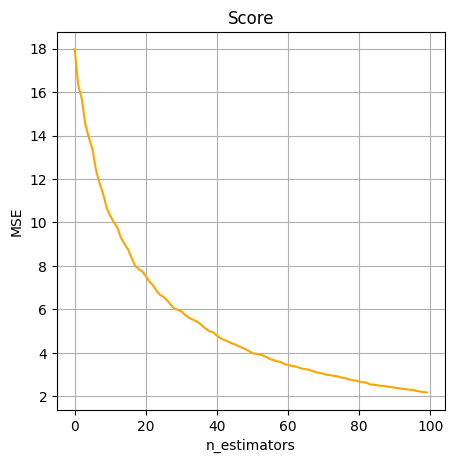

In [218]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5), dpi=100)
plt.title("Score")
plt.plot(algo.scores, color="orange")
plt.xlabel("n_estimators")
plt.ylabel("MSE")
plt.grid()
plt.show()